In [24]:
"""
# Contextual Pipeline Evaluation - Three-Way Comparison

This notebook evaluates THREE different retrieval approaches on realistic multi-turn conversation scenarios:

1. **Original (Basic)**: Standard vector similarity retrieval (90.5% on single-turn)
2. **Smart**: LLM disambiguation for overlapping categories
3. **Combined**: Smart + Contextual Retriever (LLM disambiguation + context-aware)

Unlike single-turn evaluation datasets, these scenarios test:
- Context understanding across multiple turns
- Pronoun and reference resolution
- Topic tracking and switching
- Ambiguous follow-up questions

**Use Case**: This evaluation matches real-world customer support conversations where users ask follow-up questions like "How long will it take?" or "What about that?"
"""

# Cell 2 - Code
import sys
from pathlib import Path
import json

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.rag_pipeline import RAGPipeline

print("✓ Imports loaded")

✓ Imports loaded


In [25]:
# Test scenarios based on realistic customer support conversations
CONVERSATION_TEST_SCENARIOS = [
    {
        "id": "scenario_1",
        "name": "International Transfer Follow-ups",
        "description": "Customer asks about international transfers with ambiguous follow-ups",
        "turns": [
            {
                "query": "How do I send money abroad?",
                "expected_categories": ["transfer_into_account", "transfer_timing", "country_support"],
                "context_independent": True
            },
            {
                "query": "How long will it take?",
                "expected_categories": ["transfer_timing", "transfer_into_account"],
                "context_dependent": True,
                "requires_context": "Should understand 'it' refers to international transfer"
            },
            {
                "query": "Are there any fees?",
                "expected_categories": ["transfer_fee_charged", "country_support"],
                "context_dependent": True,
                "requires_context": "Should understand asking about international transfer fees"
            },
            {
                "query": "What if it's stuck as pending?",
                "expected_categories": ["pending_transfer", "transfer_timing"],
                "context_dependent": True,
                "requires_context": "Should understand 'it' refers to international transfer"
            }
        ],
        "success_criteria": "All follow-ups should be correctly understood in context"
    },

    {
        "id": "scenario_2",
        "name": "Card Payment Issues",
        "description": "Customer reports card decline and asks follow-ups",
        "turns": [
            {
                "query": "My card payment was declined at a store",
                "expected_categories": ["declined_card_payment", "card_acceptance"],
                "context_independent": True
            },
            {
                "query": "Why did this happen?",
                "expected_categories": ["declined_card_payment"],
                "context_dependent": True,
                "requires_context": "Should understand asking about reason for card decline"
            },
            {
                "query": "Can I fix it?",
                "expected_categories": ["declined_card_payment", "contactless_not_working"],
                "context_dependent": True,
                "requires_context": "Should understand asking how to resolve card decline"
            }
        ],
        "success_criteria": "System should maintain card payment context throughout"
    },

    {
        "id": "scenario_3",
        "name": "Transfer Not Showing",
        "description": "Customer reports missing transfer with vague follow-ups",
        "turns": [
            {
                "query": "I transferred money but it's not showing in my account",
                "expected_categories": ["transfer_into_account", "balance_not_updated_after_bank_transfer"],
                "context_independent": True
            },
            {
                "query": "When will it appear?",
                "expected_categories": ["transfer_timing", "transfer_into_account"],
                "context_dependent": True,
                "requires_context": "Should understand 'it' refers to the transfer"
            },
            {
                "query": "What if it still doesn't show tomorrow?",
                "expected_categories": ["balance_not_updated_after_bank_transfer", "pending_transfer"],
                "context_dependent": True,
                "requires_context": "Should maintain transfer context"
            }
        ],
        "success_criteria": "All pronouns and implicit references correctly resolved"
    },

    {
        "id": "scenario_4",
        "name": "ATM Withdrawal Problems",
        "description": "ATM issue with card-related follow-ups",
        "turns": [
            {
                "query": "The ATM didn't give me money but charged my account",
                "expected_categories": ["atm_support", "failed_transfer", "wrong_amount_of_cash_received"],
                "context_independent": True
            },
            {
                "query": "Should I cancel my card?",
                "expected_categories": ["lost_or_stolen_card", "cancel_transfer", "compromised_card"],
                "context_dependent": True,
                "requires_context": "Card cancellation in context of ATM issue"
            },
            {
                "query": "How do I get my money back?",
                "expected_categories": ["failed_transfer", "atm_support", "request_refund"],
                "context_dependent": True,
                "requires_context": "Should understand referring to ATM withdrawal"
            }
        ],
        "success_criteria": "Context switches from ATM to card should be handled"
    },

    {
        "id": "scenario_5",
        "name": "Top-up Questions",
        "description": "Customer asks about adding money with various follow-ups",
        "turns": [
            {
                "query": "How do I add money to my account?",
                "expected_categories": ["top_up_by_card_charge", "verify_top_up", "transfer_into_account", "topping_up_by_card"],
                "context_independent": True
            },
            {
                "query": "Is there a limit?",
                "expected_categories": ["top_up_limits"],
                "context_dependent": True,
                "requires_context": "Should understand asking about top-up limit"
            },
            {
                "query": "What if it fails?",
                "expected_categories": ["top_up_failed"],
                "context_dependent": True,
                "requires_context": "Should understand 'it' refers to top-up"
            },
            {
                "query": "Are there charges?",
                "expected_categories": ["top_up_by_card_charge", "top_up_by_bank_transfer_charge"],
                "context_dependent": True,
                "requires_context": "Should understand asking about top-up charges"
            }
        ],
        "success_criteria": "All follow-ups correctly interpreted in top-up context"
    },

    {
        "id": "scenario_6",
        "name": "Lost Card Scenario",
        "description": "Customer reports lost card and asks about replacement",
        "turns": [
            {
                "query": "I lost my card and need a new one",
                "expected_categories": ["lost_or_stolen_card", "card_arrival"],
                "context_independent": True
            },
            {
                "query": "How long until it arrives?",
                "expected_categories": ["card_arrival"],
                "context_dependent": True,
                "requires_context": "Should understand 'it' refers to replacement card"
            },
            {
                "query": "Can I cancel my pending transaction?",
                "expected_categories": ["cancel_transfer", "pending_cash_withdrawal"],
                "context_dependent": True,
                "requires_context": "Context shift to different topic"
            },
            {
                "query": "Will the new one have contactless?",
                "expected_categories": ["contactless_not_working", "card_arrival"],
                "context_dependent": True,
                "requires_context": "Should understand 'new one' refers to replacement card"
            }
        ],
        "success_criteria": "Handle topic shift and return to card context"
    },

    {
        "id": "scenario_7",
        "name": "Direct Debit Issues",
        "description": "Customer confused about direct debit with follow-ups",
        "turns": [
            {
                "query": "There's a payment I don't recognize",
                "expected_categories": ["direct_debit_payment_not_recognised", "card_payment_wrong_exchange_rate", "card_payment_not_recognised"],
                "context_independent": True
            },
            {
                "query": "Could it be a direct debit?",
                "expected_categories": ["direct_debit_payment_not_recognised"],
                "context_dependent": True,
                "requires_context": "Should connect to unrecognized payment"
            },
            {
                "query": "How do I check?",
                "expected_categories": ["direct_debit_payment_not_recognised"],
                "context_dependent": True,
                "requires_context": "Should understand checking direct debits"
            }
        ],
        "success_criteria": "Maintain payment investigation context"
    },

    {
        "id": "scenario_8",
        "name": "Exchange Rate Questions",
        "description": "Currency exchange with comparative questions",
        "turns": [
            {
                "query": "What's the exchange rate for USD?",
                "expected_categories": ["exchange_rate", "card_payment_wrong_exchange_rate"],
                "context_independent": True
            },
            {
                "query": "Is it better than yesterday?",
                "expected_categories": ["exchange_rate"],
                "context_dependent": True,
                "requires_context": "Should understand 'it' refers to USD exchange rate"
            },
            {
                "query": "What about EUR?",
                "expected_categories": ["exchange_rate"],
                "context_dependent": True,
                "requires_context": "Topic shift to different currency but same domain"
            }
        ],
        "success_criteria": "Handle currency comparisons and topic shifts"
    },

    {
        "id": "scenario_9",
        "name": "Virtual Card Setup",
        "description": "Setting up virtual card with activation questions",
        "turns": [
            {
                "query": "Can I get a virtual card?",
                "expected_categories": ["getting_virtual_card", "get_disposable_virtual_card"],
                "context_independent": True
            },
            {
                "query": "Do I need to activate it?",
                "expected_categories": ["activate_my_card", "getting_virtual_card"],
                "context_dependent": True,
                "requires_context": "Should understand 'it' refers to virtual card"
            },
            {
                "query": "Where is it accepted?",
                "expected_categories": ["card_acceptance", "getting_virtual_card", "country_support"],
                "context_dependent": True,
                "requires_context": "Should understand asking about virtual card acceptance"
            },
            {
                "query": "How do I verify a transaction?",
                "expected_categories": ["verify_top_up", "card_payment_wrong_exchange_rate"],
                "context_dependent": True,
                "requires_context": "Related to virtual card transactions"
            }
        ],
        "success_criteria": "Maintain virtual card context across multiple questions"
    },

    {
        "id": "scenario_10",
        "name": "Account Balance Confusion",
        "description": "Customer confused about balance discrepancy",
        "turns": [
            {
                "query": "My balance seems wrong",
                "expected_categories": ["balance_not_updated_after_bank_transfer", "wrong_amount_of_cash_received"],
                "context_independent": True
            },
            {
                "query": "Could it be the exchange rate?",
                "expected_categories": ["card_payment_wrong_exchange_rate", "exchange_rate"],
                "context_dependent": True,
                "requires_context": "Possible cause for balance discrepancy"
            },
            {
                "query": "Or maybe a pending withdrawal?",
                "expected_categories": ["pending_cash_withdrawal", "pending_transfer"],
                "context_dependent": True,
                "requires_context": "Another possible cause"
            }
        ],
        "success_criteria": "Handle hypothetical reasoning about balance issues"
    },

    {
        "id": "scenario_11",
        "name": "Mixed Topics Conversation",
        "description": "Customer switches between unrelated topics",
        "turns": [
            {
                "query": "How do I top up my account?",
                "expected_categories": ["top_up_by_card_charge", "verify_top_up", "transfer_into_account", "topping_up_by_card"],
                "context_independent": True
            },
            {
                "query": "Actually, when will my new card arrive?",
                "expected_categories": ["card_arrival"],
                "context_dependent": False,
                "requires_context": "Complete topic change - should recognize new context"
            },
            {
                "query": "And can I use it abroad?",
                "expected_categories": ["card_acceptance", "country_support", "activate_my_card"],
                "context_dependent": True,
                "requires_context": "Should understand 'it' refers to new card, not top-up"
            }
        ],
        "success_criteria": "Handle abrupt topic changes correctly"
    },

    {
        "id": "scenario_12",
        "name": "Pronoun-Heavy Follow-ups",
        "description": "Multiple pronouns requiring careful tracking",
        "turns": [
            {
                "query": "I want to send £100 to my friend",
                "expected_categories": ["transfer_into_account", "transfer_timing", "receiving_money"],
                "context_independent": True
            },
            {
                "query": "How long will that take?",
                "expected_categories": ["transfer_timing"],
                "context_dependent": True,
                "requires_context": "'that' refers to the £100 transfer"
            },
            {
                "query": "What if they don't receive it?",
                "expected_categories": ["failed_transfer", "transfer_into_account", "transfer_not_received_by_recipient"],
                "context_dependent": True,
                "requires_context": "'they' refers to friend, 'it' refers to £100 transfer"
            },
            {
                "query": "Can I cancel that?",
                "expected_categories": ["cancel_transfer"],
                "context_dependent": True,
                "requires_context": "'that' refers to the transfer"
            }
        ],
        "success_criteria": "All pronouns correctly resolved to their referents"
    },

    {
        "id": "scenario_13",
        "name": "Implicit Comparison",
        "description": "Customer makes implicit comparisons",
        "turns": [
            {
                "query": "How much does a transfer cost?",
                "expected_categories": ["transfer_fee_charged"],
                "context_independent": True
            },
            {
                "query": "What about international?",
                "expected_categories": ["transfer_fee_charged", "country_support"],
                "context_dependent": True,
                "requires_context": "Implicit comparison - international transfer cost vs regular"
            },
            {
                "query": "Is that more expensive?",
                "expected_categories": ["transfer_fee_charged", "country_support"],
                "context_dependent": True,
                "requires_context": "Comparing international vs domestic transfer fees"
            }
        ],
        "success_criteria": "Handle implicit comparisons and contrasts"
    },

    {
        "id": "scenario_14",
        "name": "Escalating Issue",
        "description": "Problem escalates through conversation",
        "turns": [
            {
                "query": "My contactless isn't working",
                "expected_categories": ["contactless_not_working"],
                "context_independent": True
            },
            {
                "query": "Now the whole card won't work",
                "expected_categories": ["card_acceptance", "declined_card_payment", "card_not_working"],
                "context_dependent": True,
                "requires_context": "Problem escalation from contactless to entire card"
            },
            {
                "query": "Should I report it as lost?",
                "expected_categories": ["lost_or_stolen_card"],
                "context_dependent": True,
                "requires_context": "Should understand 'it' refers to malfunctioning card"
            }
        ],
        "success_criteria": "Track problem evolution through conversation"
    },

    {
        "id": "scenario_15",
        "name": "Clarification Questions",
        "description": "Customer asks for clarification on previous answer",
        "turns": [
            {
                "query": "How do I activate my card?",
                "expected_categories": ["activate_my_card"],
                "context_independent": True
            },
            {
                "query": "What do you mean by PIN?",
                "expected_categories": ["activate_my_card", "get_physical_card", "change_pin"],
                "context_dependent": True,
                "requires_context": "Clarification question about activation process"
            },
            {
                "query": "Where do I find that?",
                "expected_categories": ["activate_my_card", "card_arrival", "get_physical_card", "verify_source_of_funds"],
                "context_dependent": True,
                "requires_context": "'that' refers to PIN mentioned in clarification"
            }
        ],
        "success_criteria": "Handle meta-questions about system responses"
    }
]

print(f"✓ Loaded {len(CONVERSATION_TEST_SCENARIOS)} conversation scenarios")


✓ Loaded 15 conversation scenarios


In [26]:
# Evaluation functions
def evaluate_conversation_scenario(pipeline, scenario, verbose=False):
    """
    Evaluate a single conversation scenario
    
    Args:
        pipeline: RAGPipeline instance with contextual retriever
        scenario: Scenario dict from CONVERSATION_TEST_SCENARIOS
        verbose: Whether to print detailed results
    
    Returns:
        dict with evaluation results
    """
    pipeline.reset_conversation()
    
    results = {
        "scenario_id": scenario["id"],
        "scenario_name": scenario["name"],
        "total_turns": len(scenario["turns"]),
        "successful_turns": 0,
        "failed_turns": [],
        "turn_results": []
    }
    
    for i, turn in enumerate(scenario["turns"]):
        query = turn["query"]
        expected_cats = turn["expected_categories"]
        is_context_dependent = turn.get("context_dependent", False)
        
        # Get response
        response = pipeline.query(query, n_results=5)
        retrieved_cats = [s["category"] for s in response["sources"]]
        
        # Check if any expected category is in top-3 results
        top_3_cats = retrieved_cats[:3]
        success = any(cat in top_3_cats for cat in expected_cats)
        
        turn_result = {
            "turn": i + 1,
            "query": query,
            "context_dependent": is_context_dependent,
            "expected_categories": expected_cats,
            "retrieved_top_3": top_3_cats,
            "success": success,
            "requires_context": turn.get("requires_context", "N/A")
        }
        
        results["turn_results"].append(turn_result)
        
        if success:
            results["successful_turns"] += 1
        else:
            results["failed_turns"].append(turn_result)
    
    results["success_rate"] = results["successful_turns"] / results["total_turns"]
    results["passed"] = results["success_rate"] >= 0.75  # 75% threshold
    
    if verbose:
        print(f"\n{'='*80}")
        print(f"Scenario: {scenario['name']}")
        print(f"{'='*80}")
        print(f"Description: {scenario['description']}")
        print(f"\nResults: {results['successful_turns']}/{results['total_turns']} turns successful")
        print(f"Success Rate: {results['success_rate']:.1%}")
        print(f"Overall: {'✓ PASSED' if results['passed'] else '✗ FAILED'}")
        
        for turn_result in results["turn_results"]:
            status = "✓" if turn_result["success"] else "✗"
            context_flag = "🔗" if turn_result["context_dependent"] else "  "
            print(f"\n{status} {context_flag} Turn {turn_result['turn']}: {turn_result['query']}")
            if turn_result["requires_context"] != "N/A":
                print(f"   Context requirement: {turn_result['requires_context']}")
            print(f"   Expected: {', '.join(turn_result['expected_categories'])}")
            print(f"   Retrieved: {', '.join(turn_result['retrieved_top_3'])}")
    
    return results


def evaluate_all_scenarios(pipeline, verbose=False):
    """
    Evaluate all conversation scenarios
    
    Args:
        pipeline: RAGPipeline instance
        verbose: Whether to print detailed results
    
    Returns:
        dict with overall evaluation results
    """
    all_results = []
    
    for scenario in CONVERSATION_TEST_SCENARIOS:
        result = evaluate_conversation_scenario(pipeline, scenario, verbose=verbose)
        all_results.append(result)
    
    # Calculate overall statistics
    total_scenarios = len(all_results)
    passed_scenarios = sum(1 for r in all_results if r["passed"])
    total_turns = sum(r["total_turns"] for r in all_results)
    successful_turns = sum(r["successful_turns"] for r in all_results)
    
    context_dependent_turns = []
    context_independent_turns = []
    
    for result in all_results:
        for turn in result["turn_results"]:
            if turn["context_dependent"]:
                context_dependent_turns.append(turn["success"])
            else:
                context_independent_turns.append(turn["success"])
    
    overall = {
        "total_scenarios": total_scenarios,
        "passed_scenarios": passed_scenarios,
        "scenario_success_rate": passed_scenarios / total_scenarios,
        "total_turns": total_turns,
        "successful_turns": successful_turns,
        "overall_turn_success_rate": successful_turns / total_turns,
        "context_dependent_accuracy": sum(context_dependent_turns) / len(context_dependent_turns) if context_dependent_turns else 0,
        "context_independent_accuracy": sum(context_independent_turns) / len(context_independent_turns) if context_independent_turns else 0,
        "scenario_results": all_results
    }
    
    if verbose:
        print(f"\n{'='*80}")
        print("OVERALL RESULTS")
        print(f"{'='*80}")
        print(f"\nScenarios: {passed_scenarios}/{total_scenarios} passed ({overall['scenario_success_rate']:.1%})")
        print(f"Total Turns: {successful_turns}/{total_turns} successful ({overall['overall_turn_success_rate']:.1%})")
        print(f"\nContext-Dependent Turns: {sum(context_dependent_turns)}/{len(context_dependent_turns)} ({overall['context_dependent_accuracy']:.1%})")
        print(f"Context-Independent Turns: {sum(context_independent_turns)}/{len(context_independent_turns)} ({overall['context_independent_accuracy']:.1%})")
        
        print(f"\n{'='*80}")
        print("SCENARIO BREAKDOWN")
        print(f"{'='*80}")
        for result in all_results:
            status = "✓ PASS" if result["passed"] else "✗ FAIL"
            print(f"{status} - {result['scenario_name']}: {result['successful_turns']}/{result['total_turns']} ({result['success_rate']:.0%})")
    
    return overall

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [27]:
## Initialize All Three Pipelines
"""
1. **Original**: Basic vector similarity retrieval (no smart features, no context)
2. **Smart**: LLM disambiguation for overlapping categories (uses GPT-4o-mini to classify ambiguous queries)
3. **Combined**: Smart + Contextual (LLM disambiguation + conversation context tracking)
"""
# Path to vector database
vector_db_path = str(project_root / "data" / "vector_db")

# 1. Original Pipeline (Basic Retrieval - 90.5% on single-turn)
print("Initializing Original (Basic) Pipeline...")
original_pipeline = RAGPipeline(
    vector_db_path=vector_db_path,
    model="gpt-4o-mini",
    use_contextual_retriever=False,  # No context
    use_smart_retriever=False        # No smart features
)
print("✓ Original pipeline initialized (basic vector similarity only)")

# 2. Smart Pipeline (LLM Disambiguation, No Context)
print("\nInitializing Smart Pipeline...")
smart_pipeline = RAGPipeline(
    vector_db_path=vector_db_path,
    model="gpt-4o-mini",
    use_contextual_retriever=False,  # No context
    use_smart_retriever=True         # Enable LLM disambiguation
)
print("✓ Smart pipeline initialized (LLM disambiguation for overlapping categories)")

# 3. Combined Pipeline (Smart + Contextual)
print("\nInitializing Combined (Smart + Contextual) Pipeline...")
combined_pipeline = RAGPipeline(
    vector_db_path=vector_db_path,
    model="gpt-4o-mini",
    use_contextual_retriever=True,   # Enable context tracking
    use_smart_retriever=True         # Enable LLM disambiguation
)
print("✓ Combined pipeline initialized (LLM disambiguation + context tracking)")

print("\n" + "="*80)
print("ALL PIPELINES READY FOR EVALUATION")
print("="*80)
print("\nPipeline Configurations:")
print("  1. Original: Vector similarity only")
print("  2. Smart:    Vector similarity + LLM disambiguation")
print("  3. Combined: Vector similarity + LLM disambiguation + context tracking")


Initializing Original (Basic) Pipeline...

[*] Building RAG Pipeline...
  [+] Base retriever initialized
  [+] Generator initialized (model: gpt-4o-mini)
[+] Pipeline ready!

✓ Original pipeline initialized (basic vector similarity only)

Initializing Smart Pipeline...

[*] Building RAG Pipeline...
  [+] Base retriever initialized
  [+] Smart retrieval enabled
     - Confidence threshold: 0.38
     - Gap threshold: 0.1
     - Handles: overlapping categories (declined_card_payment vs card_not_working)
     - Expected trigger rate: ~20-30% of queries
  [+] Generator initialized (model: gpt-4o-mini)
[+] Pipeline ready!

✓ Smart pipeline initialized (LLM disambiguation for overlapping categories)

Initializing Combined (Smart + Contextual) Pipeline...

[*] Building RAG Pipeline...
  [+] Base retriever initialized
  [+] Smart retrieval enabled
     - Confidence threshold: 0.38
     - Gap threshold: 0.1
     - Handles: overlapping categories (declined_card_payment vs card_not_working)
     -

In [28]:
## Preview Test Scenarios

# Let's look at what types of conversations we're testing
# Show summary of all scenarios
print(f"{'='*80}")
print("CONVERSATION TEST SCENARIOS")
print(f"{'='*80}\n")

for i, scenario in enumerate(CONVERSATION_TEST_SCENARIOS, 1):
    n_turns = len(scenario['turns'])
    context_dependent = sum(1 for t in scenario['turns'] if t.get('context_dependent', False))
    
    print(f"{i:2d}. {scenario['name']}")
    print(f"    {scenario['description']}")
    print(f"    Turns: {n_turns} ({context_dependent} context-dependent)")
    print()



CONVERSATION TEST SCENARIOS

 1. International Transfer Follow-ups
    Customer asks about international transfers with ambiguous follow-ups
    Turns: 4 (3 context-dependent)

 2. Card Payment Issues
    Customer reports card decline and asks follow-ups
    Turns: 3 (2 context-dependent)

 3. Transfer Not Showing
    Customer reports missing transfer with vague follow-ups
    Turns: 3 (2 context-dependent)

 4. ATM Withdrawal Problems
    ATM issue with card-related follow-ups
    Turns: 3 (2 context-dependent)

 5. Top-up Questions
    Customer asks about adding money with various follow-ups
    Turns: 4 (3 context-dependent)

 6. Lost Card Scenario
    Customer reports lost card and asks about replacement
    Turns: 4 (3 context-dependent)

 7. Direct Debit Issues
    Customer confused about direct debit with follow-ups
    Turns: 3 (2 context-dependent)

 8. Exchange Rate Questions
    Currency exchange with comparative questions
    Turns: 3 (2 context-dependent)

 9. Virtual Card

In [29]:
## Run Evaluations on All Three Pipelines

# This will take a few minutes as we run 15 scenarios × 3 pipelines = 45 evaluations

# Evaluate Original (Basic) Pipeline
print("="*80)
print("EVALUATING ORIGINAL (BASIC) PIPELINE")
print("="*80)
original_results = evaluate_all_scenarios(original_pipeline, verbose=True)

EVALUATING ORIGINAL (BASIC) PIPELINE

Scenario: International Transfer Follow-ups
Description: Customer asks about international transfers with ambiguous follow-ups

Results: 4/4 turns successful
Success Rate: 100.0%
Overall: ✓ PASSED

✓    Turn 1: How do I send money abroad?
   Expected: transfer_into_account, transfer_timing, country_support
   Retrieved: receiving_money, exchange_charge, transfer_into_account

✓ 🔗 Turn 2: How long will it take?
   Context requirement: Should understand 'it' refers to international transfer
   Expected: transfer_timing, transfer_into_account
   Retrieved: pending_transfer, transfer_timing, transfer_not_received_by_recipient

✓ 🔗 Turn 3: Are there any fees?
   Context requirement: Should understand asking about international transfer fees
   Expected: transfer_fee_charged, country_support
   Retrieved: transfer_fee_charged, card_payment_fee_charged, card_payment_fee_charged

✓ 🔗 Turn 4: What if it's stuck as pending?
   Context requirement: Should und

In [30]:
# Evaluate Smart Pipeline
print("\n" + "="*80)
print("EVALUATING SMART PIPELINE")
print("="*80)
smart_results = evaluate_all_scenarios(smart_pipeline, verbose=True)



EVALUATING SMART PIPELINE
[SMART RETRIEVAL] Low confidence detected (sim=0.064, gap=-0.095)
[SMART RETRIEVAL] Using LLM to disambiguate between: exchange_rate, receiving_money
[DEBUG] Query received by SmartRetriever: 'How do I send money abroad?'
[DEBUG] Is fee query: False (checking: ['fee', 'fees', 'charge', 'charged', 'cost', 'costs', 'international transaction', 'exchange rate', 'currency'])
[DEBUG] Candidates before force-add: ['exchange_rate', 'receiving_money', 'exchange_charge', 'transfer_into_account', 'exchange_via_app', 'transfer_fee_charged', 'fiat_currency_support']
[SMART RETRIEVAL] Final candidates (7): ['exchange_rate', 'receiving_money', 'exchange_charge', 'transfer_into_account', 'exchange_via_app', 'transfer_fee_charged', 'fiat_currency_support']
[LLM] Selected: transfer_fee_charged
[SMART RETRIEVAL] Low confidence detected (sim=-0.168, gap=-0.031)
[SMART RETRIEVAL] Using LLM to disambiguate between: transfer_timing, transfer_timing
[DEBUG] Query received by SmartR

In [31]:
# Evaluate Combined (Smart + Contextual) Pipeline
print("\n" + "="*80)
print("EVALUATING COMBINED (SMART + CONTEXTUAL) PIPELINE")
print("="*80)
combined_results = evaluate_all_scenarios(combined_pipeline, verbose=True)



EVALUATING COMBINED (SMART + CONTEXTUAL) PIPELINE
[SMART RETRIEVAL] Low confidence detected (sim=0.064, gap=-0.095)
[SMART RETRIEVAL] Using LLM to disambiguate between: exchange_rate, receiving_money
[DEBUG] Query received by SmartRetriever: 'How do I send money abroad?'
[DEBUG] Is fee query: False (checking: ['fee', 'fees', 'charge', 'charged', 'cost', 'costs', 'international transaction', 'exchange rate', 'currency'])
[DEBUG] Candidates before force-add: ['exchange_rate', 'receiving_money', 'exchange_charge', 'transfer_into_account', 'exchange_via_app', 'transfer_fee_charged', 'fiat_currency_support']
[SMART RETRIEVAL] Final candidates (7): ['exchange_rate', 'receiving_money', 'exchange_charge', 'transfer_into_account', 'exchange_via_app', 'transfer_fee_charged', 'fiat_currency_support']
[LLM] Selected: transfer_fee_charged
[SMART RETRIEVAL] Low confidence detected (sim=-0.168, gap=-0.031)
[SMART RETRIEVAL] Using LLM to disambiguate between: transfer_timing, transfer_timing
[DEBUG] 

In [32]:
## Three-Way Comparison Summary
print("\n" + "="*80)
print("PERFORMANCE COMPARISON: Original → Smart → Combined")
print("="*80)
print()

print(f"{'Metric':<35} {'Original':<12} {'Smart':<12} {'Combined':<12} {'Total Δ'}")
print("-"*80)

metrics = [
    ("Scenario Success", 
     original_results['scenario_success_rate'], 
     smart_results['scenario_success_rate'],
     combined_results['scenario_success_rate']),
    ("Overall Accuracy", 
     original_results['overall_turn_success_rate'], 
     smart_results['overall_turn_success_rate'],
     combined_results['overall_turn_success_rate']),
    ("Context-Independent", 
     original_results['context_independent_accuracy'], 
     smart_results['context_independent_accuracy'],
     combined_results['context_independent_accuracy']),
    ("Context-Dependent", 
     original_results['context_dependent_accuracy'], 
     smart_results['context_dependent_accuracy'],
     combined_results['context_dependent_accuracy']),
]

for metric_name, orig_val, smart_val, combined_val in metrics:
    total_improvement = combined_val - orig_val
    arrow = "↑" if total_improvement > 0 else "↓" if total_improvement < 0 else "→"
    print(f"{metric_name:<35} {orig_val:>6.1%}      {smart_val:>6.1%}      {combined_val:>6.1%}      {arrow} {abs(total_improvement):>5.1%}")

print("\n" + "="*80)
print()

# Show progression analysis
print("📊 PROGRESSION ANALYSIS:")
print()
print(f"Original (90.5% on single-turn) → Smart → Combined")
print(f"Context-Dependent: {original_results['context_dependent_accuracy']:.1%} → {smart_results['context_dependent_accuracy']:.1%} → {combined_results['context_dependent_accuracy']:.1%}")
print(f"Overall: {original_results['overall_turn_success_rate']:.1%} → {smart_results['overall_turn_success_rate']:.1%} → {combined_results['overall_turn_success_rate']:.1%}")



PERFORMANCE COMPARISON: Original → Smart → Combined

Metric                              Original     Smart        Combined     Total Δ
--------------------------------------------------------------------------------
Scenario Success                     53.3%       66.7%      100.0%      ↑ 46.7%
Overall Accuracy                     82.0%       82.0%       96.0%      ↑ 14.0%
Context-Independent                  87.5%       93.8%       93.8%      ↑  6.2%
Context-Dependent                    79.4%       76.5%       97.1%      ↑ 17.6%


📊 PROGRESSION ANALYSIS:

Original (90.5% on single-turn) → Smart → Combined
Context-Dependent: 79.4% → 76.5% → 97.1%
Overall: 82.0% → 82.0% → 96.0%


In [33]:
## Detailed Scenario-by-Scenario Comparison
print("="*80)
print("SCENARIO-BY-SCENARIO COMPARISON")
print("="*80)
print()

print(f"{'Scenario':<40} {'Original':<10} {'Smart':<10} {'Combined':<10}")
print("-"*80)

for i, scenario in enumerate(CONVERSATION_TEST_SCENARIOS):
    scenario_name = scenario['name']
    orig_rate = original_results['scenario_results'][i]['success_rate']
    smart_rate = smart_results['scenario_results'][i]['success_rate']
    combined_rate = combined_results['scenario_results'][i]['success_rate']
    
    print(f"{scenario_name:<40} {orig_rate:>6.0%}     {smart_rate:>6.0%}     {combined_rate:>6.0%}")


SCENARIO-BY-SCENARIO COMPARISON

Scenario                                 Original   Smart      Combined  
--------------------------------------------------------------------------------
International Transfer Follow-ups          100%        50%        75%
Card Payment Issues                         67%        33%       100%
Transfer Not Showing                        67%       100%       100%
ATM Withdrawal Problems                    100%       100%       100%
Top-up Questions                           100%       100%       100%
Lost Card Scenario                         100%        75%        75%
Direct Debit Issues                         67%        67%       100%
Exchange Rate Questions                     67%        67%       100%
Virtual Card Setup                         100%       100%       100%
Account Balance Confusion                  100%       100%       100%
Mixed Topics Conversation                   67%       100%       100%
Pronoun-Heavy Follow-ups                  

In [34]:
## Analyze Failure Cases by Pipeline
def get_failures(results):
    """Extract all failed turns from results"""
    failures = []
    for scenario_result in results['scenario_results']:
        for failed_turn in scenario_result['failed_turns']:
            failures.append({
                'scenario': scenario_result['scenario_name'],
                'turn': failed_turn['turn'],
                'query': failed_turn['query'],
                'expected': failed_turn['expected_categories'],
                'retrieved': failed_turn['retrieved_top_3'],
                'context_dependent': failed_turn['context_dependent']
            })
    return failures

original_failures = get_failures(original_results)
smart_failures = get_failures(smart_results)
combined_failures = get_failures(combined_results)

print("="*80)
print("FAILURE ANALYSIS")
print("="*80)
print()
print(f"Original Pipeline:  {len(original_failures)} failed turns")
print(f"Smart Pipeline:     {len(smart_failures)} failed turns")
print(f"Combined Pipeline:  {len(combined_failures)} failed turns")
print()


FAILURE ANALYSIS

Original Pipeline:  9 failed turns
Smart Pipeline:     9 failed turns
Combined Pipeline:  2 failed turns



In [35]:
# Show failures unique to each pipeline
print("="*80)
print("COMBINED PIPELINE FAILURES (What Still Needs Work)")
print("="*80)
print()

if combined_failures:
    for i, failure in enumerate(combined_failures, 1):
        context_flag = "🔗" if failure['context_dependent'] else "  "
        print(f"{i}. {context_flag} {failure['scenario']} - Turn {failure['turn']}")
        print(f"   Query: {failure['query']}")
        print(f"   Expected: {', '.join(failure['expected'])}")
        print(f"   Retrieved: {', '.join(failure['retrieved'])}")
        print()
else:
    print("🎉 Perfect score! All turns passed!")


COMBINED PIPELINE FAILURES (What Still Needs Work)

1.    International Transfer Follow-ups - Turn 1
   Query: How do I send money abroad?
   Expected: transfer_into_account, transfer_timing, country_support
   Retrieved: transfer_fee_charged, transfer_fee_charged

2. 🔗 Lost Card Scenario - Turn 2
   Query: How long until it arrives?
   Expected: card_arrival
   Retrieved: card_delivery_estimate



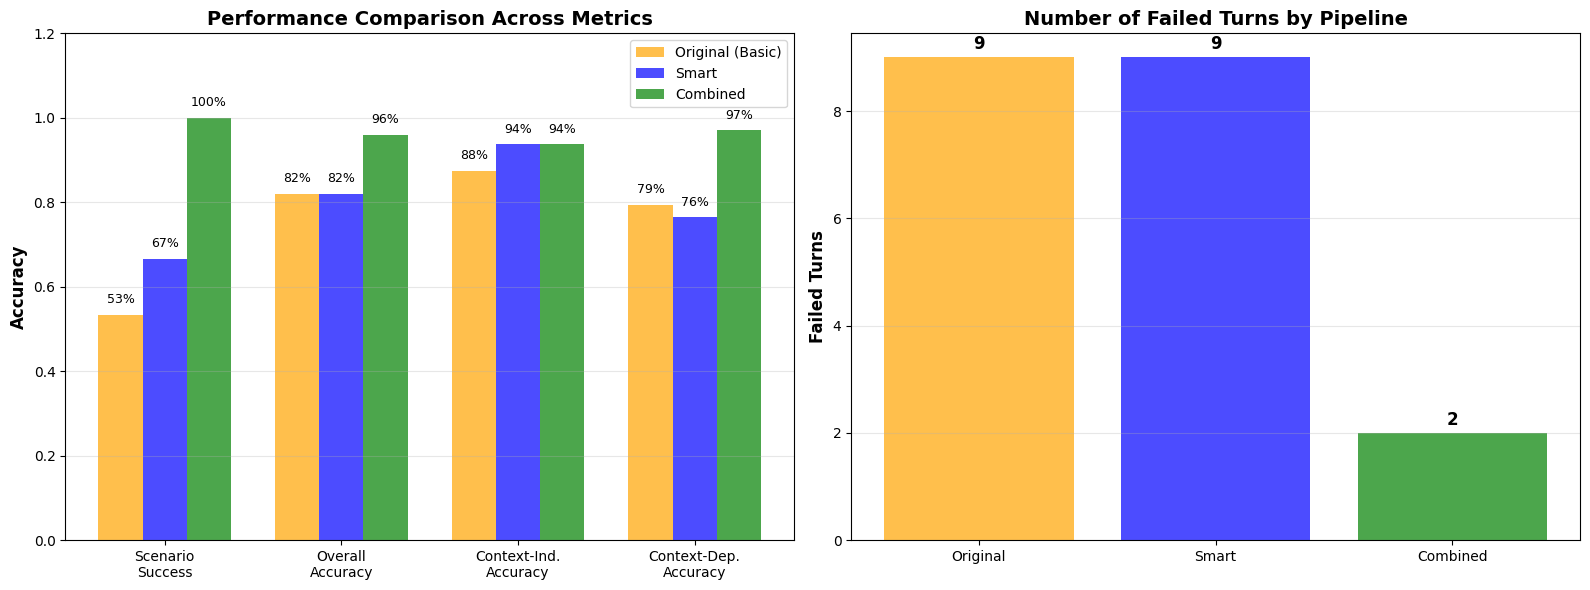


✓ Comparison chart saved as 'three_way_comparison.png'


In [40]:
## Visualization: Three-Way Comparison
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Overall Metrics Comparison
categories = ['Scenario\nSuccess', 'Overall\nAccuracy', 'Context-Ind.\nAccuracy', 'Context-Dep.\nAccuracy']
original_scores = [
    original_results['scenario_success_rate'],
    original_results['overall_turn_success_rate'],
    original_results['context_independent_accuracy'],
    original_results['context_dependent_accuracy']
]
smart_scores = [
    smart_results['scenario_success_rate'],
    smart_results['overall_turn_success_rate'],
    smart_results['context_independent_accuracy'],
    smart_results['context_dependent_accuracy']
]
combined_scores = [
    combined_results['scenario_success_rate'],
    combined_results['overall_turn_success_rate'],
    combined_results['context_independent_accuracy'],
    combined_results['context_dependent_accuracy']
]

x = np.arange(len(categories))
width = 0.25

bars1 = ax1.bar(x - width, original_scores, width, label='Original (Basic)', color='orange', alpha=0.7)
bars2 = ax1.bar(x, smart_scores, width, label='Smart', color='blue', alpha=0.7)
bars3 = ax1.bar(x + width, combined_scores, width, label='Combined', color='green', alpha=0.7)

ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Performance Comparison Across Metrics', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.set_ylim(0, 1.2)
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.0%}', ha='center', va='bottom', fontsize=9)

# Chart 2: Failure Count Comparison
ax2.bar(['Original', 'Smart', 'Combined'], 
        [len(original_failures), len(smart_failures), len(combined_failures)],
        color=['orange', 'blue', 'green'], alpha=0.7)
ax2.set_ylabel('Failed Turns', fontsize=12, fontweight='bold')
ax2.set_title('Number of Failed Turns by Pipeline', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add count labels
for i, (label, count) in enumerate(zip(['Original', 'Smart', 'Combined'], 
                                        [len(original_failures), len(smart_failures), len(combined_failures)])):
    ax2.text(i, count + 0.15, str(count), ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(project_root / 'three_way_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison chart saved as 'three_way_comparison.png'")


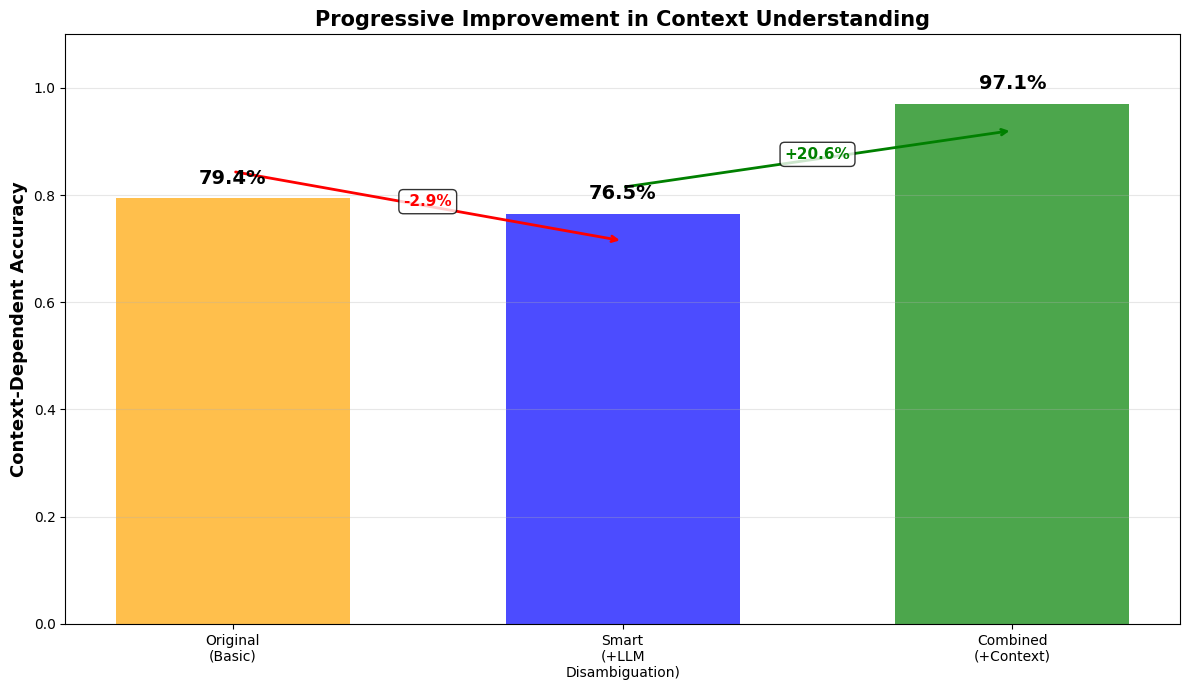


✓ Progression chart saved as 'context_progression.png'


In [37]:
## Progression Visualization: Context-Dependent Performance
# Create progression chart showing improvement from Original → Smart → Combined
fig, ax = plt.subplots(figsize=(12, 7))

pipeline_names = ['Original\n(Basic)', 'Smart\n(+LLM\nDisambiguation)', 'Combined\n(+Context)']
context_dep_scores = [
    original_results['context_dependent_accuracy'],
    smart_results['context_dependent_accuracy'],
    combined_results['context_dependent_accuracy']
]

bars = ax.bar(pipeline_names, context_dep_scores, color=['orange', 'blue', 'green'], alpha=0.7, width=0.6)

# Add arrow annotations showing improvement
for i in range(len(context_dep_scores) - 1):
    improvement = context_dep_scores[i+1] - context_dep_scores[i]
    arrow_color = 'green' if improvement > 0 else 'red'
    
    ax.annotate('', xy=(i+1, context_dep_scores[i+1] - 0.05), 
                xytext=(i, context_dep_scores[i] + 0.05),
                arrowprops=dict(arrowstyle='->', color=arrow_color, lw=2))
    
    mid_x = i + 0.5
    mid_y = (context_dep_scores[i] + context_dep_scores[i+1]) / 2
    ax.text(mid_x, mid_y, f'{improvement:+.1%}', ha='center', fontsize=11, 
            fontweight='bold', color=arrow_color, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add percentage labels on bars
for bar, score in zip(bars, context_dep_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.1%}', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Context-Dependent Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Progressive Improvement in Context Understanding', fontsize=15, fontweight='bold')
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'context_progression.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Progression chart saved as 'context_progression.png'")


In [38]:
## Export Results
from datetime import datetime

# Save comprehensive comparison results
results_file = project_root / "data" / "evaluation_results" / "three_way_comparison.json"
results_file.parent.mkdir(parents=True, exist_ok=True)

export_data = {
    "evaluation_date": datetime.now().isoformat(),
    "evaluation_type": "three_way_pipeline_comparison",
    "pipelines": {
        "original": {
            "config": {
                "use_contextual_retriever": False,
                "use_smart_retriever": False,
                "description": "Basic vector similarity retrieval (90.5% on single-turn)"
            },
            "results": {
                "scenario_success_rate": float(original_results['scenario_success_rate']),
                "overall_accuracy": float(original_results['overall_turn_success_rate']),
                "context_independent_accuracy": float(original_results['context_independent_accuracy']),
                "context_dependent_accuracy": float(original_results['context_dependent_accuracy']),
                "failed_turns": len(original_failures)
            }
        },
        "smart": {
            "config": {
                "use_contextual_retriever": False,
                "use_smart_retriever": True,
                "description": "LLM disambiguation for overlapping categories"
            },
            "results": {
                "scenario_success_rate": float(smart_results['scenario_success_rate']),
                "overall_accuracy": float(smart_results['overall_turn_success_rate']),
                "context_independent_accuracy": float(smart_results['context_independent_accuracy']),
                "context_dependent_accuracy": float(smart_results['context_dependent_accuracy']),
                "failed_turns": len(smart_failures)
            }
        },
        "combined": {
            "config": {
                "use_contextual_retriever": True,
                "use_smart_retriever": True,
                "description": "LLM disambiguation + contextual understanding"
            },
            "results": {
                "scenario_success_rate": float(combined_results['scenario_success_rate']),
                "overall_accuracy": float(combined_results['overall_turn_success_rate']),
                "context_independent_accuracy": float(combined_results['context_independent_accuracy']),
                "context_dependent_accuracy": float(combined_results['context_dependent_accuracy']),
                "failed_turns": len(combined_failures)
            }
        }
    },
    "scenario_details": {
        "original": original_results['scenario_results'],
        "smart": smart_results['scenario_results'],
        "combined": combined_results['scenario_results']
    }
}

with open(results_file, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"✓ Comprehensive results saved to: {results_file}")


✓ Comprehensive results saved to: c:\Users\victo\customer-support-rag\data\evaluation_results\three_way_comparison.json
